In [1]:
from utils.alloys import alloy_to_1d_tensor, make_params_df, get_elements_and_compositions
from utils.constants import alloy_max_len, n_elements
from utils.ml import *
from utils.dataframes import dfs_tabs
from utils.rnn_predictor import LSTMClassifier, LSTMClassifierBidirectional, save_model_and_see_stats, save_predictions
from utils.ml import run_all_regressors, run_all_regressors_with_transformers
import torch
import matplotlib.pyplot as plt

2023-09-29 13:03:41.045561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 13:03:41.549976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-29 13:03:42.576707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-09-29 13:03:42.577157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

In [2]:
df_train = pd.read_csv("train_final_df.csv")
df_test = pd.read_csv("test_final_df.csv")

print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (1269, 3)
Testing set shape: (318, 3)


In [3]:
# constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ideally a max factor is from the training dataset
max_factor = max(df_train["actual_d_max"])
print(max_factor)

35.0


In [4]:
def alloy_to_vectorized_tensor(alloy_str, alloy_max_len = alloy_max_len):
    elements_vector_df = pd.read_csv("utils/elements_wvmodel_2016_12-15-20.csv")
    tensor = torch.zeros(alloy_max_len, 200)
    elements, compositions = get_elements_and_compositions(alloy_str)
    i = 0
    j = 0
    for idx in range(0, len(elements) + len(compositions), 2):
        tensor[j, :] = torch.tensor(np.array(elements_vector_df[elements[i]]))
        tensor[j, int(compositions[i])] = 1
        i += 1
        j += 2
    return tensor

# creating the input and output data for the model
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_vectorized_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

for i in range(df_test.shape[0]):
    X_test.append(alloy_to_vectorized_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
# max_factor we selected is fine
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("X_train (shape and min-max):", X_train.shape, min(X_train.view(-1, 1)), max(X_train.view(-1, 1)),
      "y_train (shape and min-max):", y_train.shape, min(y_train.view(-1, 1)), max(y_train.view(-1, 1)))

print("X_test (shape and min-max):", X_test.shape, min(X_test.view(-1, 1)), max(X_test.view(-1, 1)),
      "y_test (shape and min-max):", y_test.shape, min(y_test.view(-1, 1)), max(y_test.view(-1, 1)))

X_train (shape and min-max): torch.Size([1269, 20, 200]) tensor([-1.1398]) tensor([1.]) y_train (shape and min-max): torch.Size([1269]) tensor([0.]) tensor([1.])
X_test (shape and min-max): torch.Size([318, 20, 200]) tensor([-1.1398]) tensor([1.]) y_test (shape and min-max): torch.Size([318]) tensor([0.]) tensor([0.8571])


In [5]:
input_size = 200
hidden_size = 128
learning_rate = 0.001
num_epochs = 2500
batch_size = 32
num_layers = 3

class LSTMClassifierBidirectional(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x
    
model = LSTMClassifierBidirectional(input_size, hidden_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifierBidirectional(
  (lstm): LSTM(200, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [6]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
y_train_tensor = y_train_tensor.unsqueeze(1)

# Create a PyTorch DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
print_every = 100
plot_loss = []
# TODO: print the average loss
# EDIT: we are printing epoch loss of batch

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the batches of data
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        # print("output", outputs.squeeze(), "\nlabel", labels)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    
    # Print the loss for this epoch
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    plot_loss.append(epoch_loss)

Epoch 1/2500, Loss: 0.3747
Epoch 101/2500, Loss: 0.2295
Epoch 201/2500, Loss: 0.2271
Epoch 301/2500, Loss: 0.2296
Epoch 401/2500, Loss: 0.2278
Epoch 501/2500, Loss: 0.2283
Epoch 601/2500, Loss: 0.2270
Epoch 701/2500, Loss: 0.2269
Epoch 801/2500, Loss: 0.2268
Epoch 901/2500, Loss: 0.2273
Epoch 1001/2500, Loss: 0.2280
Epoch 1101/2500, Loss: 0.2266
Epoch 1201/2500, Loss: 0.2278
Epoch 1301/2500, Loss: 0.2279
Epoch 1401/2500, Loss: 0.2269
Epoch 1501/2500, Loss: 0.2272
Epoch 1601/2500, Loss: 0.2269
Epoch 1701/2500, Loss: 0.2275
Epoch 1801/2500, Loss: 0.2276
Epoch 1901/2500, Loss: 0.2266
Epoch 2001/2500, Loss: 0.2268
Epoch 2101/2500, Loss: 0.2270
Epoch 2201/2500, Loss: 0.2270
Epoch 2301/2500, Loss: 0.2275
Epoch 2401/2500, Loss: 0.2269


R2 Score: 0.7221


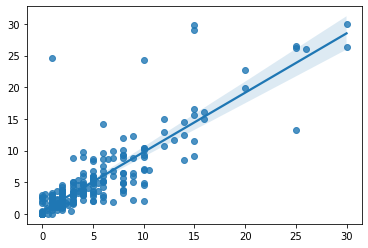

In [8]:
save_model_and_see_stats(model=model, model_file_name="rnn_method_3", 
                         X_test=X_test, y_test=y_test, max_factor=max_factor)

In [10]:
save_predictions(alloy_to_vectorized_tensor=alloy_to_vectorized_tensor, 
                 model=model, max_factor=max_factor, 
                 df_train=df_train, df_test=df_test, 
                 output_file_name="dataset_rnn_method_3")

In [11]:
df_train_with_params = make_params_df(df_train)
display(df_train_with_params)
df_test_with_params = make_params_df(df_test)
display(df_test_with_params)

,bmg_alloy,paper_sno,actual_d_max,rnn_encoding,h_mix,s_mix,delta_d,delta_e
0,B6.0Cr16.0Fe78.0,[9],0.00,0.00,17.04,0.66,0.03,0.05
1,B22.3Fe66.9Mo3.72Dy7.0,[9],2.00,1.99,22.50,0.91,0.13,-0.10
2,Mg11.0Ca55.0Cu23.0Zn11.0,"[5, 7]",1.00,1.01,9.47,1.15,0.37,-0.27
3,Mg84.5Mn8.0Y7.5,[9],0.00,0.00,9.26,0.54,0.17,0.03
4,Al95.0Co3.0Ce2.0,[9],0.00,0.00,10.76,0.23,0.22,-0.18
...,...,...,...,...,...,...,...,...
1264,Cu55.0Ga5.0Zr40.0,"[9, 5, 7]",2.00,2.01,15.88,0.85,0.25,-0.16
1265,B20.0Si4.0Fe71.2Cu0.8Nb4.0,[2],1.00,1.34,23.01,0.86,0.28,-0.01
1266,Mg25.0Ca55.0Zn20.0,"[9, 5, 7]",1.00,1.01,8.34,1.00,0.32,-0.19
1267,B6.0C15.0Cr4.0Mn10.0Fe53.0Mo12.0,[2],3.00,3.02,32.52,1.40,0.13,-0.16


,bmg_alloy,paper_sno,actual_d_max,rnn_encoding,h_mix,s_mix,delta_d,delta_e
0,Ni50.0Cu40.0Hf10.0,[9],0.00,1.74,16.39,0.94,0.28,-0.19
1,Al8.0Cu36.0Zr46.0Pd2.0Ag8.0,"[1, 6]",30.00,29.99,16.46,1.21,0.22,-0.15
2,Al25.0Co20.0Tm55.0,"[5, 7]",3.00,3.44,15.16,1.00,0.17,-0.16
3,B4.0C4.0Si2.0P10.0Fe75.0Ga3.0Mo2.0,"[1, 2, 5, 6, 9]",2.50,1.46,18.51,0.97,0.09,-0.11
4,Al2.0Cu90.0Ce8.0,[9],0.00,0.00,12.44,0.38,0.40,-0.26
...,...,...,...,...,...,...,...,...
313,B2.0Fe86.0Mo12.0,[9],0.00,0.00,17.19,0.46,0.02,-0.04
314,Fe42.0Cu41.0Ag17.0,[9],0.00,0.00,13.09,1.03,0.25,-0.01
315,Be23.0Ti24.0Fe6.0Ni10.0Cu9.0Zr28.0,"[1, 6]",4.00,6.05,15.92,1.65,0.19,-0.08
316,Mg22.5Ca50.0Cu27.5,"[9, 5, 7]",10.00,7.05,9.82,1.04,0.33,-0.24


In [12]:
X_train = df_train_with_params[['rnn_encoding', 'h_mix', 's_mix', 'delta_d', 'delta_e']]
y_train = df_train_with_params[['actual_d_max']]

X_test = df_test_with_params[['rnn_encoding', 'h_mix', 's_mix', 'delta_d', 'delta_e']]
y_test = df_test_with_params[['actual_d_max']]

In [13]:
run_all_regressors(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

 14%|████████████                                                                        | 6/42 [00:00<00:01, 28.56it/s]

AdaBoostRegressor 0.6907019267636104
BaggingRegressor 0.700523517907158
BayesianRidge 0.7219639834224942
DecisionTreeRegressor 0.7102634426681412
DummyRegressor -0.005335325313598593
ElasticNet 0.7374150811073463
ElasticNetCV 0.7228712761210059
ExtraTreeRegressor 0.7109513132689358


 24%|███████████████████▊                                                               | 10/42 [00:00<00:01, 24.83it/s]

ExtraTreesRegressor 0.722111432001317
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor -3.3750052420765915
GradientBoostingRegressor 0.7093934432533489


 31%|█████████████████████████▋                                                         | 13/42 [00:01<00:03,  8.24it/s]

HistGradientBoostingRegressor 0.70211007523803
HuberRegressor 0.7220007918977298
KNeighborsRegressor 0.7143511984002988


 48%|███████████████████████████████████████▌                                           | 20/42 [00:01<00:01, 12.69it/s]

KernelRidge 0.72197613000596
Lars 0.7219638563603217
LarsCV 0.7220740638873574
Lasso 0.7376871243751622
LassoCV 0.7224408047377696
LassoLars 0.7376871243751622
LassoLarsCV 0.7220740638873574
LassoLarsIC 0.722040261360968
LinearRegression 0.7219638563603217
LinearSVR 0.7222761364829084


 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:03<00:02,  5.85it/s]

MLPRegressor 0.7207107538884109
NuSVR 0.7506210659130382
OrthogonalMatchingPursuit 0.7220072695311384
OrthogonalMatchingPursuitCV 0.7220072695311384
PassiveAggressiveRegressor 0.7227238686288824
PoissonRegressor 0.21151535164760937
RANSACRegressor 0.7219638563603213


 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:04<00:01,  7.98it/s]

RandomForestRegressor 0.7069544115339086
Ridge 0.7219829631399008
RidgeCV 0.7219829631290875
SGDRegressor 0.722532685494802
SVR 0.7528307679175941
TransformedTargetRegressor 0.7219638563603217
TweedieRegressor 0.7374478108600127


 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  6.97it/s]

XGBRegressor 0.7092193815897931
LGBMRegressor 0.7215597333507413
Learning rate set to 0.042513
0:	learn: 4.8278517	total: 52.3ms	remaining: 52.2s
1:	learn: 4.6671563	total: 53.7ms	remaining: 26.8s
2:	learn: 4.5059957	total: 54.3ms	remaining: 18.1s
3:	learn: 4.3590347	total: 55.1ms	remaining: 13.7s
4:	learn: 4.2051490	total: 55.8ms	remaining: 11.1s
5:	learn: 4.0648070	total: 56.5ms	remaining: 9.36s
6:	learn: 3.9177249	total: 57.1ms	remaining: 8.1s
7:	learn: 3.7778853	total: 57.8ms	remaining: 7.16s
8:	learn: 3.6461287	total: 58.4ms	remaining: 6.43s
9:	learn: 3.5195801	total: 59.3ms	remaining: 5.87s
10:	learn: 3.4075443	total: 60.1ms	remaining: 5.4s
11:	learn: 3.2867184	total: 60.9ms	remaining: 5.01s
12:	learn: 3.1685154	total: 61.7ms	remaining: 4.69s
13:	learn: 3.0699597	total: 62.4ms	remaining: 4.39s
14:	learn: 2.9648732	total: 63.1ms	remaining: 4.14s
15:	learn: 2.8722962	total: 63.8ms	remaining: 3.92s
16:	learn: 2.7768906	total: 64.7ms	remaining: 3.74s
17:	learn: 2.6756446	total: 65.3m

245:	learn: 0.2000374	total: 242ms	remaining: 741ms
246:	learn: 0.1996872	total: 243ms	remaining: 740ms
247:	learn: 0.1991787	total: 244ms	remaining: 739ms
248:	learn: 0.1986179	total: 245ms	remaining: 738ms
249:	learn: 0.1981567	total: 245ms	remaining: 736ms
250:	learn: 0.1977399	total: 246ms	remaining: 734ms
251:	learn: 0.1974682	total: 247ms	remaining: 732ms
252:	learn: 0.1970167	total: 248ms	remaining: 731ms
253:	learn: 0.1965208	total: 248ms	remaining: 730ms
254:	learn: 0.1960859	total: 249ms	remaining: 728ms
255:	learn: 0.1956740	total: 250ms	remaining: 727ms
256:	learn: 0.1953758	total: 251ms	remaining: 726ms
257:	learn: 0.1948864	total: 252ms	remaining: 726ms
258:	learn: 0.1945147	total: 253ms	remaining: 725ms
259:	learn: 0.1943064	total: 254ms	remaining: 723ms
260:	learn: 0.1938050	total: 255ms	remaining: 722ms
261:	learn: 0.1935500	total: 256ms	remaining: 721ms
262:	learn: 0.1933029	total: 257ms	remaining: 720ms
263:	learn: 0.1929767	total: 258ms	remaining: 719ms
264:	learn: 

473:	learn: 0.1366615	total: 431ms	remaining: 478ms
474:	learn: 0.1364223	total: 432ms	remaining: 477ms
475:	learn: 0.1363035	total: 433ms	remaining: 476ms
476:	learn: 0.1360057	total: 433ms	remaining: 475ms
477:	learn: 0.1357907	total: 434ms	remaining: 474ms
478:	learn: 0.1355384	total: 438ms	remaining: 477ms
479:	learn: 0.1353387	total: 439ms	remaining: 476ms
480:	learn: 0.1352442	total: 440ms	remaining: 475ms
481:	learn: 0.1350043	total: 441ms	remaining: 474ms
482:	learn: 0.1348439	total: 442ms	remaining: 473ms
483:	learn: 0.1346026	total: 443ms	remaining: 472ms
484:	learn: 0.1344075	total: 444ms	remaining: 471ms
485:	learn: 0.1341706	total: 444ms	remaining: 470ms
486:	learn: 0.1340396	total: 446ms	remaining: 470ms
487:	learn: 0.1339158	total: 448ms	remaining: 470ms
488:	learn: 0.1337689	total: 449ms	remaining: 469ms
489:	learn: 0.1336354	total: 451ms	remaining: 469ms
490:	learn: 0.1335213	total: 452ms	remaining: 468ms
491:	learn: 0.1332723	total: 454ms	remaining: 468ms
492:	learn: 

697:	learn: 0.1018353	total: 620ms	remaining: 268ms
698:	learn: 0.1017692	total: 621ms	remaining: 268ms
699:	learn: 0.1017099	total: 622ms	remaining: 267ms
700:	learn: 0.1015850	total: 623ms	remaining: 266ms
701:	learn: 0.1014918	total: 624ms	remaining: 265ms
702:	learn: 0.1013627	total: 624ms	remaining: 264ms
703:	learn: 0.1012995	total: 625ms	remaining: 263ms
704:	learn: 0.1012247	total: 626ms	remaining: 262ms
705:	learn: 0.1011642	total: 627ms	remaining: 261ms
706:	learn: 0.1011047	total: 628ms	remaining: 260ms
707:	learn: 0.1009493	total: 628ms	remaining: 259ms
708:	learn: 0.1008161	total: 629ms	remaining: 258ms
709:	learn: 0.1007386	total: 630ms	remaining: 257ms
710:	learn: 0.1006766	total: 631ms	remaining: 256ms
711:	learn: 0.1006096	total: 632ms	remaining: 255ms
712:	learn: 0.1005418	total: 633ms	remaining: 255ms
713:	learn: 0.1004311	total: 633ms	remaining: 254ms
714:	learn: 0.1002508	total: 638ms	remaining: 254ms
715:	learn: 0.1001075	total: 639ms	remaining: 253ms
716:	learn: 

100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]

926:	learn: 0.0810101	total: 810ms	remaining: 63.8ms
927:	learn: 0.0809253	total: 811ms	remaining: 62.9ms
928:	learn: 0.0808527	total: 811ms	remaining: 62ms
929:	learn: 0.0807550	total: 812ms	remaining: 61.1ms
930:	learn: 0.0807159	total: 813ms	remaining: 60.3ms
931:	learn: 0.0806502	total: 814ms	remaining: 59.4ms
932:	learn: 0.0806071	total: 815ms	remaining: 58.5ms
933:	learn: 0.0805696	total: 815ms	remaining: 57.6ms
934:	learn: 0.0804701	total: 816ms	remaining: 56.7ms
935:	learn: 0.0803947	total: 817ms	remaining: 55.9ms
936:	learn: 0.0802784	total: 818ms	remaining: 55ms
937:	learn: 0.0801620	total: 819ms	remaining: 54.1ms
938:	learn: 0.0800961	total: 820ms	remaining: 53.3ms
939:	learn: 0.0800547	total: 821ms	remaining: 52.4ms
940:	learn: 0.0799270	total: 822ms	remaining: 51.5ms
941:	learn: 0.0798581	total: 823ms	remaining: 50.7ms
942:	learn: 0.0798179	total: 824ms	remaining: 49.8ms
943:	learn: 0.0797918	total: 825ms	remaining: 48.9ms
944:	learn: 0.0797603	total: 826ms	remaining: 48.1

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.75,0.75,2.54,0.03
NuSVR,0.75,0.75,2.55,0.12
LassoLars,0.73,0.74,2.62,0.01
Lasso,0.73,0.74,2.62,0.00
TweedieRegressor,0.73,0.74,2.62,0.01
ElasticNet,0.73,0.74,2.62,0.01
CatBoostRegressor,0.73,0.73,2.64,1.06
ElasticNetCV,0.72,0.72,2.69,0.07
PassiveAggressiveRegressor,0.72,0.72,2.69,0.02


In [14]:
run_all_regressors_with_transformers(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (StandardScaler) 0.6891922214857333



  5%|████                                                                                | 2/42 [00:00<00:02, 18.82it/s]

BaggingRegressor (StandardScaler) 0.7115407682078391
BayesianRidge (StandardScaler) 0.7219639785590396
DecisionTreeRegressor (StandardScaler) 0.7095472461403441
DummyRegressor (StandardScaler) -0.005335325313598593
ElasticNet (StandardScaler) 0.4953333527229514
ElasticNetCV (StandardScaler) 0.7228711451634796
ExtraTreeRegressor (StandardScaler) 0.7147575073368997



 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 33.91it/s]

ExtraTreesRegressor (StandardScaler) 0.7226130401385842
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (StandardScaler) -1.945854167144745



 31%|█████████████████████████▋                                                         | 13/42 [00:00<00:02, 12.69it/s]

GradientBoostingRegressor (StandardScaler) 0.7093934517117411
HistGradientBoostingRegressor (StandardScaler) 0.7021100751663376



 38%|███████████████████████████████▌                                                   | 16/42 [00:01<00:01, 14.15it/s]

HuberRegressor (StandardScaler) 0.7220007937976999
KNeighborsRegressor (StandardScaler) 0.731989794234533
KernelRidge (StandardScaler) 0.7224182522713329
Lars (StandardScaler) 0.7219638563603217
LarsCV (StandardScaler) 0.7221018037231178
Lasso (StandardScaler) -0.005335325313598593



 48%|███████████████████████████████████████▌                                           | 20/42 [00:01<00:01, 18.11it/s]

LassoCV (StandardScaler) 0.7224408047377694
LassoLars (StandardScaler) -0.005335325313598593
LassoLarsCV (StandardScaler) 0.7221018037231178
LassoLarsIC (StandardScaler) 0.7220455200493345
LinearRegression (StandardScaler) 0.7219638563603217
LinearSVR (StandardScaler) 0.7220773983820041



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:03<00:02,  5.71it/s]

MLPRegressor (StandardScaler) 0.7210134407493554



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:03<00:02,  5.80it/s]

NuSVR (StandardScaler) 0.725920558377348
OrthogonalMatchingPursuit (StandardScaler) 0.7220072695311386
OrthogonalMatchingPursuitCV (StandardScaler) 0.7220072695311386
PassiveAggressiveRegressor (StandardScaler) 0.7244011994070536
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) 0.7219638563603217



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:03<00:00, 12.63it/s]

RandomForestRegressor (StandardScaler) 0.7059359365443183
Ridge (StandardScaler) 0.7224182522713327
RidgeCV (StandardScaler) 0.7220094456931614
SGDRegressor (StandardScaler) 0.7226972845520448
SVR (StandardScaler) 0.7225919555108102
TransformedTargetRegressor (StandardScaler) 0.7219638563603217
TweedieRegressor (StandardScaler) 0.6789385239817816
XGBRegressor (StandardScaler) 0.7095141395169997
LGBMRegressor (StandardScaler) 0.7211731912187612
Learning rate set to 0.042513
0:	learn: 0.9670120	total: 1.74ms	remaining: 1.74s
1:	learn: 0.9366758	total: 2.47ms	remaining: 1.23s
2:	learn: 0.9047783	total: 3.34ms	remaining: 1.11s
3:	learn: 0.8733778	total: 4.07ms	remaining: 1.01s
4:	learn: 0.8424429	total: 5.02ms	remaining: 1000ms
5:	learn: 0.8131021	total: 6.79ms	remaining: 1.13s
6:	learn: 0.7849893	total: 7.82ms	remaining: 1.11s
7:	learn: 0.7580624	total: 8.72ms	remaining: 1.08s
8:	learn: 0.7323802	total: 9.61ms	remaining: 1.06s
9:	learn: 0.7076994	total: 10.4ms	remaining: 1.02s
10:	learn: 

195:	learn: 0.0464132	total: 201ms	remaining: 824ms
196:	learn: 0.0462677	total: 202ms	remaining: 824ms
197:	learn: 0.0461077	total: 203ms	remaining: 823ms
198:	learn: 0.0459659	total: 204ms	remaining: 821ms
199:	learn: 0.0458567	total: 205ms	remaining: 819ms
200:	learn: 0.0457775	total: 206ms	remaining: 819ms
201:	learn: 0.0456786	total: 207ms	remaining: 817ms
202:	learn: 0.0454842	total: 207ms	remaining: 814ms
203:	learn: 0.0453618	total: 210ms	remaining: 818ms
204:	learn: 0.0451991	total: 211ms	remaining: 819ms
205:	learn: 0.0450686	total: 212ms	remaining: 819ms
206:	learn: 0.0449920	total: 213ms	remaining: 817ms
207:	learn: 0.0448871	total: 214ms	remaining: 815ms
208:	learn: 0.0447401	total: 215ms	remaining: 813ms
209:	learn: 0.0446242	total: 216ms	remaining: 812ms
210:	learn: 0.0444671	total: 217ms	remaining: 812ms
211:	learn: 0.0443018	total: 218ms	remaining: 811ms
212:	learn: 0.0442379	total: 219ms	remaining: 810ms
213:	learn: 0.0440786	total: 220ms	remaining: 810ms
214:	learn: 

386:	learn: 0.0311107	total: 391ms	remaining: 619ms
387:	learn: 0.0310615	total: 391ms	remaining: 617ms
388:	learn: 0.0309732	total: 393ms	remaining: 617ms
389:	learn: 0.0309069	total: 394ms	remaining: 616ms
390:	learn: 0.0308889	total: 395ms	remaining: 615ms
391:	learn: 0.0308733	total: 395ms	remaining: 613ms
392:	learn: 0.0307897	total: 396ms	remaining: 612ms
393:	learn: 0.0307483	total: 397ms	remaining: 611ms
394:	learn: 0.0306447	total: 398ms	remaining: 610ms
395:	learn: 0.0305769	total: 399ms	remaining: 609ms
396:	learn: 0.0305060	total: 400ms	remaining: 607ms
397:	learn: 0.0304607	total: 401ms	remaining: 606ms
398:	learn: 0.0303929	total: 402ms	remaining: 605ms
399:	learn: 0.0303178	total: 402ms	remaining: 604ms
400:	learn: 0.0302368	total: 403ms	remaining: 602ms
401:	learn: 0.0301947	total: 405ms	remaining: 602ms
402:	learn: 0.0301698	total: 406ms	remaining: 602ms
403:	learn: 0.0301292	total: 407ms	remaining: 601ms
404:	learn: 0.0300734	total: 413ms	remaining: 607ms
405:	learn: 

572:	learn: 0.0231807	total: 580ms	remaining: 432ms
573:	learn: 0.0231251	total: 581ms	remaining: 431ms
574:	learn: 0.0231001	total: 582ms	remaining: 430ms
575:	learn: 0.0230684	total: 583ms	remaining: 429ms
576:	learn: 0.0230207	total: 584ms	remaining: 428ms
577:	learn: 0.0229993	total: 585ms	remaining: 427ms
578:	learn: 0.0229785	total: 587ms	remaining: 427ms
579:	learn: 0.0229313	total: 588ms	remaining: 426ms
580:	learn: 0.0228997	total: 589ms	remaining: 425ms
581:	learn: 0.0228639	total: 589ms	remaining: 423ms
582:	learn: 0.0228469	total: 590ms	remaining: 422ms
583:	learn: 0.0228009	total: 591ms	remaining: 421ms
584:	learn: 0.0227814	total: 592ms	remaining: 420ms
585:	learn: 0.0227654	total: 593ms	remaining: 419ms
586:	learn: 0.0227168	total: 594ms	remaining: 418ms
587:	learn: 0.0226868	total: 595ms	remaining: 417ms
588:	learn: 0.0226690	total: 596ms	remaining: 416ms
589:	learn: 0.0226274	total: 597ms	remaining: 415ms
590:	learn: 0.0225877	total: 598ms	remaining: 414ms
591:	learn: 

752:	learn: 0.0186045	total: 768ms	remaining: 252ms
753:	learn: 0.0185910	total: 769ms	remaining: 251ms
754:	learn: 0.0185727	total: 770ms	remaining: 250ms
755:	learn: 0.0185522	total: 771ms	remaining: 249ms
756:	learn: 0.0185373	total: 772ms	remaining: 248ms
757:	learn: 0.0185022	total: 774ms	remaining: 247ms
758:	learn: 0.0184723	total: 780ms	remaining: 248ms
759:	learn: 0.0184563	total: 781ms	remaining: 247ms
760:	learn: 0.0184361	total: 782ms	remaining: 246ms
761:	learn: 0.0184258	total: 783ms	remaining: 245ms
762:	learn: 0.0183995	total: 784ms	remaining: 243ms
763:	learn: 0.0183798	total: 785ms	remaining: 242ms
764:	learn: 0.0183559	total: 786ms	remaining: 241ms
765:	learn: 0.0183346	total: 787ms	remaining: 240ms
766:	learn: 0.0183186	total: 788ms	remaining: 240ms
767:	learn: 0.0183047	total: 790ms	remaining: 239ms
768:	learn: 0.0182704	total: 791ms	remaining: 237ms
769:	learn: 0.0182575	total: 791ms	remaining: 236ms
770:	learn: 0.0182302	total: 792ms	remaining: 235ms
771:	learn: 

 17%|██████████████▏                                                                      | 1/6 [00:04<00:24,  4.99s/it]

951:	learn: 0.0151426	total: 957ms	remaining: 48.2ms
952:	learn: 0.0151317	total: 958ms	remaining: 47.2ms
953:	learn: 0.0151188	total: 958ms	remaining: 46.2ms
954:	learn: 0.0150998	total: 959ms	remaining: 45.2ms
955:	learn: 0.0150817	total: 960ms	remaining: 44.2ms
956:	learn: 0.0150675	total: 961ms	remaining: 43.2ms
957:	learn: 0.0150510	total: 962ms	remaining: 42.2ms
958:	learn: 0.0150359	total: 963ms	remaining: 41.2ms
959:	learn: 0.0150238	total: 963ms	remaining: 40.1ms
960:	learn: 0.0150034	total: 964ms	remaining: 39.1ms
961:	learn: 0.0149777	total: 965ms	remaining: 38.1ms
962:	learn: 0.0149623	total: 966ms	remaining: 37.1ms
963:	learn: 0.0149541	total: 967ms	remaining: 36.1ms
964:	learn: 0.0149443	total: 968ms	remaining: 35.1ms
965:	learn: 0.0149352	total: 969ms	remaining: 34.1ms
966:	learn: 0.0149152	total: 970ms	remaining: 33.1ms
967:	learn: 0.0148968	total: 971ms	remaining: 32.1ms
968:	learn: 0.0148855	total: 972ms	remaining: 31.1ms
969:	learn: 0.0148761	total: 973ms	remaining: 


  7%|██████                                                                              | 3/42 [00:00<00:01, 28.05it/s]

AdaBoostRegressor (MinMaxScaler) 0.689077968037182
BaggingRegressor (MinMaxScaler) 0.7072392915322769
BayesianRidge (MinMaxScaler) 0.7219639787252953
DecisionTreeRegressor (MinMaxScaler) 0.7102682510278783
DummyRegressor (MinMaxScaler) -0.005335325313598371
ElasticNet (MinMaxScaler) -0.005335325313598371
ElasticNetCV (MinMaxScaler) 0.7228796490191964
ExtraTreeRegressor (MinMaxScaler) 0.7097068356000192



 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 33.25it/s]

ExtraTreesRegressor (MinMaxScaler) 0.7221993466232808
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MinMaxScaler) 0.7210313212066075
GradientBoostingRegressor (MinMaxScaler) 0.7093864404660046



 38%|███████████████████████████████▌                                                   | 16/42 [00:01<00:01, 13.90it/s]

HistGradientBoostingRegressor (MinMaxScaler) 0.7021100860732221
HuberRegressor (MinMaxScaler) 0.7220007665203911
KNeighborsRegressor (MinMaxScaler) 0.7384943561215114
KernelRidge (MinMaxScaler) 0.7408632136956033
Lars (MinMaxScaler) 0.7219638563603218
LarsCV (MinMaxScaler) 0.7220964587065387



 48%|███████████████████████████████████████▌                                           | 20/42 [00:01<00:01, 17.91it/s]

Lasso (MinMaxScaler) -0.005335325313598371
LassoCV (MinMaxScaler) 0.7224408047377696
LassoLars (MinMaxScaler) -0.005335325313598371
LassoLarsCV (MinMaxScaler) 0.7220964587065387
LassoLarsIC (MinMaxScaler) 0.7220610271619258
LinearRegression (MinMaxScaler) 0.7219638563603215
LinearSVR (MinMaxScaler) 0.7215056144521448



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:01<00:01, 12.29it/s]

MLPRegressor (MinMaxScaler) 0.7097304332187819



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:02<00:01,  9.30it/s]

NuSVR (MinMaxScaler) 0.721562538255341
OrthogonalMatchingPursuit (MinMaxScaler) 0.7220072695311386
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.7220072695311386
PassiveAggressiveRegressor (MinMaxScaler) 0.7281027362350323
PoissonRegressor (MinMaxScaler) 0.0006434010815782321
RANSACRegressor (MinMaxScaler) 0.7219638563603213



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:02<00:00, 17.57it/s]

RandomForestRegressor (MinMaxScaler) 0.7024220824355465
Ridge (MinMaxScaler) 0.7410048691221334
RidgeCV (MinMaxScaler) 0.7241846963145563
SGDRegressor (MinMaxScaler) 0.44795768833819205
SVR (MinMaxScaler) 0.6138813075125974
TransformedTargetRegressor (MinMaxScaler) 0.7219638563603215
TweedieRegressor (MinMaxScaler) 0.051899681807576314
XGBRegressor (MinMaxScaler) 0.7093357139607809
LGBMRegressor (MinMaxScaler) 0.7059371890303847
Learning rate set to 0.042513
0:	learn: 0.1379386	total: 848us	remaining: 847ms
1:	learn: 0.1333473	total: 1.65ms	remaining: 821ms
2:	learn: 0.1287427	total: 2.59ms	remaining: 861ms
3:	learn: 0.1245439	total: 3.62ms	remaining: 900ms
4:	learn: 0.1201471	total: 4.72ms	remaining: 940ms
5:	learn: 0.1161373	total: 5.71ms	remaining: 947ms
6:	learn: 0.1119350	total: 6.47ms	remaining: 918ms
7:	learn: 0.1079396	total: 7.49ms	remaining: 929ms
8:	learn: 0.1041751	total: 8.34ms	remaining: 919ms
9:	learn: 0.1005594	total: 9.08ms	remaining: 899ms
10:	learn: 0.0973584	total: 

240:	learn: 0.0057644	total: 241ms	remaining: 759ms
241:	learn: 0.0057526	total: 242ms	remaining: 759ms
242:	learn: 0.0057377	total: 243ms	remaining: 758ms
243:	learn: 0.0057248	total: 244ms	remaining: 757ms
244:	learn: 0.0057123	total: 246ms	remaining: 757ms
245:	learn: 0.0057076	total: 247ms	remaining: 756ms
246:	learn: 0.0056952	total: 248ms	remaining: 755ms
247:	learn: 0.0056820	total: 249ms	remaining: 754ms
248:	learn: 0.0056703	total: 249ms	remaining: 752ms
249:	learn: 0.0056641	total: 251ms	remaining: 752ms
250:	learn: 0.0056567	total: 251ms	remaining: 750ms
251:	learn: 0.0056471	total: 252ms	remaining: 749ms
252:	learn: 0.0056264	total: 254ms	remaining: 749ms
253:	learn: 0.0056175	total: 254ms	remaining: 747ms
254:	learn: 0.0056103	total: 255ms	remaining: 746ms
255:	learn: 0.0056040	total: 256ms	remaining: 744ms
256:	learn: 0.0055942	total: 259ms	remaining: 748ms
257:	learn: 0.0055827	total: 260ms	remaining: 749ms
258:	learn: 0.0055760	total: 266ms	remaining: 762ms
259:	learn: 

416:	learn: 0.0042943	total: 431ms	remaining: 602ms
417:	learn: 0.0042899	total: 432ms	remaining: 601ms
418:	learn: 0.0042837	total: 433ms	remaining: 600ms
419:	learn: 0.0042745	total: 434ms	remaining: 599ms
420:	learn: 0.0042630	total: 435ms	remaining: 598ms
421:	learn: 0.0042566	total: 436ms	remaining: 597ms
422:	learn: 0.0042519	total: 437ms	remaining: 596ms
423:	learn: 0.0042400	total: 438ms	remaining: 595ms
424:	learn: 0.0042314	total: 439ms	remaining: 594ms
425:	learn: 0.0042279	total: 440ms	remaining: 592ms
426:	learn: 0.0042185	total: 441ms	remaining: 592ms
427:	learn: 0.0042065	total: 442ms	remaining: 591ms
428:	learn: 0.0042017	total: 443ms	remaining: 590ms
429:	learn: 0.0041976	total: 444ms	remaining: 589ms
430:	learn: 0.0041925	total: 445ms	remaining: 588ms
431:	learn: 0.0041871	total: 447ms	remaining: 587ms
432:	learn: 0.0041814	total: 448ms	remaining: 586ms
433:	learn: 0.0041717	total: 449ms	remaining: 585ms
434:	learn: 0.0041669	total: 450ms	remaining: 584ms
435:	learn: 

614:	learn: 0.0032637	total: 620ms	remaining: 388ms
615:	learn: 0.0032587	total: 622ms	remaining: 388ms
616:	learn: 0.0032548	total: 623ms	remaining: 387ms
617:	learn: 0.0032519	total: 624ms	remaining: 386ms
618:	learn: 0.0032478	total: 624ms	remaining: 384ms
619:	learn: 0.0032457	total: 625ms	remaining: 383ms
620:	learn: 0.0032439	total: 626ms	remaining: 382ms
621:	learn: 0.0032418	total: 627ms	remaining: 381ms
622:	learn: 0.0032383	total: 628ms	remaining: 380ms
623:	learn: 0.0032360	total: 629ms	remaining: 379ms
624:	learn: 0.0032331	total: 631ms	remaining: 378ms
625:	learn: 0.0032298	total: 631ms	remaining: 377ms
626:	learn: 0.0032246	total: 632ms	remaining: 376ms
627:	learn: 0.0032205	total: 633ms	remaining: 375ms
628:	learn: 0.0032153	total: 634ms	remaining: 374ms
629:	learn: 0.0032134	total: 635ms	remaining: 373ms
630:	learn: 0.0032097	total: 636ms	remaining: 372ms
631:	learn: 0.0032076	total: 637ms	remaining: 371ms
632:	learn: 0.0032058	total: 638ms	remaining: 370ms
633:	learn: 

 33%|████████████████████████████▎                                                        | 2/6 [00:08<00:17,  4.32s/it]

821:	learn: 0.0026356	total: 810ms	remaining: 175ms
822:	learn: 0.0026329	total: 811ms	remaining: 174ms
823:	learn: 0.0026268	total: 812ms	remaining: 173ms
824:	learn: 0.0026252	total: 813ms	remaining: 172ms
825:	learn: 0.0026232	total: 814ms	remaining: 171ms
826:	learn: 0.0026213	total: 815ms	remaining: 170ms
827:	learn: 0.0026192	total: 816ms	remaining: 169ms
828:	learn: 0.0026149	total: 816ms	remaining: 168ms
829:	learn: 0.0026110	total: 817ms	remaining: 167ms
830:	learn: 0.0026073	total: 818ms	remaining: 166ms
831:	learn: 0.0026047	total: 819ms	remaining: 165ms
832:	learn: 0.0026029	total: 820ms	remaining: 164ms
833:	learn: 0.0026007	total: 821ms	remaining: 163ms
834:	learn: 0.0025987	total: 822ms	remaining: 162ms
835:	learn: 0.0025970	total: 823ms	remaining: 161ms
836:	learn: 0.0025955	total: 824ms	remaining: 161ms
837:	learn: 0.0025943	total: 825ms	remaining: 160ms
838:	learn: 0.0025919	total: 826ms	remaining: 159ms
839:	learn: 0.0025893	total: 827ms	remaining: 158ms
840:	learn: 


  7%|██████                                                                              | 3/42 [00:00<00:01, 28.53it/s]

AdaBoostRegressor (MaxAbsScaler) 0.691757036634929
BaggingRegressor (MaxAbsScaler) 0.7008376782837504
BayesianRidge (MaxAbsScaler) 0.7219639787269395
DecisionTreeRegressor (MaxAbsScaler) 0.7104218180169827
DummyRegressor (MaxAbsScaler) -0.005335325313598371
ElasticNet (MaxAbsScaler) -0.005335325313598371
ElasticNetCV (MaxAbsScaler) 0.7228748901059655
ExtraTreeRegressor (MaxAbsScaler) 0.7161128753980738



 21%|██████████████████                                                                  | 9/42 [00:00<00:01, 32.05it/s]

ExtraTreesRegressor (MaxAbsScaler) 0.7212430674331896
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MaxAbsScaler) 0.720496562442746



 31%|█████████████████████████▋                                                         | 13/42 [00:00<00:02, 10.86it/s]

GradientBoostingRegressor (MaxAbsScaler) 0.7093864404660047
HistGradientBoostingRegressor (MaxAbsScaler) 0.7026073732970515



 38%|███████████████████████████████▌                                                   | 16/42 [00:01<00:02, 11.52it/s]

HuberRegressor (MaxAbsScaler) 0.7220008000015105
KNeighborsRegressor (MaxAbsScaler) 0.7387505309830171
KernelRidge (MaxAbsScaler) 0.7407338266683414



 48%|███████████████████████████████████████▌                                           | 20/42 [00:01<00:01, 15.03it/s]

Lars (MaxAbsScaler) 0.721963856360322
LarsCV (MaxAbsScaler) 0.7221030735521615
Lasso (MaxAbsScaler) -0.005335325313598371
LassoCV (MaxAbsScaler) 0.7224408047377695
LassoLars (MaxAbsScaler) -0.005335325313598371
LassoLarsCV (MaxAbsScaler) 0.7221030735521615
LassoLarsIC (MaxAbsScaler) 0.7220711467245712
LinearRegression (MaxAbsScaler) 0.7219638563603215
LinearSVR (MaxAbsScaler) 0.7217429797720547



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:02<00:01, 10.89it/s]

MLPRegressor (MaxAbsScaler) 0.7066204861023885



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:02<00:01,  8.67it/s]

NuSVR (MaxAbsScaler) 0.7217625932825715
OrthogonalMatchingPursuit (MaxAbsScaler) 0.7220072695311387
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.7220072695311387
PassiveAggressiveRegressor (MaxAbsScaler) 0.7135503267977994
PoissonRegressor (MaxAbsScaler) 0.0010804105484997217
RANSACRegressor (MaxAbsScaler) 0.7219638563603215



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:02<00:00, 17.99it/s]

RandomForestRegressor (MaxAbsScaler) 0.7042650027735379
Ridge (MaxAbsScaler) 0.740990731783413
RidgeCV (MaxAbsScaler) 0.7241845062212379
SGDRegressor (MaxAbsScaler) 0.4411566679908069
SVR (MaxAbsScaler) 0.5816237435630687
TransformedTargetRegressor (MaxAbsScaler) 0.7219638563603215
TweedieRegressor (MaxAbsScaler) 0.054961121176292815
XGBRegressor (MaxAbsScaler) 0.7093357139607809
LGBMRegressor (MaxAbsScaler) 0.7218892554741059
Learning rate set to 0.042513
0:	learn: 0.1379386	total: 1.33ms	remaining: 1.33s
1:	learn: 0.1333473	total: 2.37ms	remaining: 1.18s
2:	learn: 0.1287427	total: 3.4ms	remaining: 1.13s
3:	learn: 0.1245439	total: 4.49ms	remaining: 1.12s
4:	learn: 0.1201471	total: 5.36ms	remaining: 1.07s
5:	learn: 0.1161373	total: 6.1ms	remaining: 1.01s
6:	learn: 0.1119350	total: 6.97ms	remaining: 990ms
7:	learn: 0.1079396	total: 7.79ms	remaining: 967ms
8:	learn: 0.1041751	total: 8.56ms	remaining: 943ms
9:	learn: 0.1005594	total: 9.38ms	remaining: 929ms
10:	learn: 0.0973584	total: 10.

278:	learn: 0.0053887	total: 250ms	remaining: 646ms
279:	learn: 0.0053760	total: 251ms	remaining: 646ms
280:	learn: 0.0053667	total: 252ms	remaining: 644ms
281:	learn: 0.0053631	total: 253ms	remaining: 643ms
282:	learn: 0.0053486	total: 254ms	remaining: 643ms
283:	learn: 0.0053372	total: 255ms	remaining: 643ms
284:	learn: 0.0053251	total: 256ms	remaining: 642ms
285:	learn: 0.0053142	total: 257ms	remaining: 641ms
286:	learn: 0.0053099	total: 258ms	remaining: 641ms
287:	learn: 0.0053064	total: 259ms	remaining: 641ms
288:	learn: 0.0052942	total: 261ms	remaining: 641ms
289:	learn: 0.0052908	total: 262ms	remaining: 642ms
290:	learn: 0.0052829	total: 263ms	remaining: 642ms
291:	learn: 0.0052800	total: 264ms	remaining: 641ms
292:	learn: 0.0052733	total: 265ms	remaining: 640ms
293:	learn: 0.0052581	total: 267ms	remaining: 640ms
294:	learn: 0.0052471	total: 268ms	remaining: 640ms
295:	learn: 0.0052364	total: 269ms	remaining: 639ms
296:	learn: 0.0052332	total: 270ms	remaining: 639ms
297:	learn: 

479:	learn: 0.0038911	total: 440ms	remaining: 476ms
480:	learn: 0.0038874	total: 441ms	remaining: 476ms
481:	learn: 0.0038840	total: 442ms	remaining: 475ms
482:	learn: 0.0038805	total: 443ms	remaining: 474ms
483:	learn: 0.0038762	total: 444ms	remaining: 473ms
484:	learn: 0.0038722	total: 445ms	remaining: 472ms
485:	learn: 0.0038686	total: 446ms	remaining: 471ms
486:	learn: 0.0038610	total: 446ms	remaining: 470ms
487:	learn: 0.0038587	total: 447ms	remaining: 469ms
488:	learn: 0.0038525	total: 448ms	remaining: 468ms
489:	learn: 0.0038490	total: 450ms	remaining: 468ms
490:	learn: 0.0038433	total: 451ms	remaining: 467ms
491:	learn: 0.0038348	total: 452ms	remaining: 467ms
492:	learn: 0.0038315	total: 453ms	remaining: 466ms
493:	learn: 0.0038232	total: 454ms	remaining: 465ms
494:	learn: 0.0038203	total: 455ms	remaining: 464ms
495:	learn: 0.0038170	total: 456ms	remaining: 463ms
496:	learn: 0.0038133	total: 457ms	remaining: 463ms
497:	learn: 0.0038098	total: 458ms	remaining: 462ms
498:	learn: 

690:	learn: 0.0030195	total: 630ms	remaining: 282ms
691:	learn: 0.0030127	total: 631ms	remaining: 281ms
692:	learn: 0.0030101	total: 632ms	remaining: 280ms
693:	learn: 0.0030075	total: 633ms	remaining: 279ms
694:	learn: 0.0030049	total: 634ms	remaining: 278ms
695:	learn: 0.0030024	total: 635ms	remaining: 277ms
696:	learn: 0.0029990	total: 636ms	remaining: 276ms
697:	learn: 0.0029967	total: 637ms	remaining: 276ms
698:	learn: 0.0029916	total: 638ms	remaining: 275ms
699:	learn: 0.0029881	total: 639ms	remaining: 274ms
700:	learn: 0.0029861	total: 640ms	remaining: 273ms
701:	learn: 0.0029839	total: 641ms	remaining: 272ms
702:	learn: 0.0029772	total: 642ms	remaining: 271ms
703:	learn: 0.0029757	total: 643ms	remaining: 270ms
704:	learn: 0.0029730	total: 644ms	remaining: 269ms
705:	learn: 0.0029708	total: 644ms	remaining: 268ms
706:	learn: 0.0029661	total: 645ms	remaining: 267ms
707:	learn: 0.0029640	total: 646ms	remaining: 267ms
708:	learn: 0.0029617	total: 647ms	remaining: 266ms
709:	learn: 

 50%|██████████████████████████████████████████▌                                          | 3/6 [00:12<00:12,  4.14s/it]

897:	learn: 0.0024276	total: 820ms	remaining: 93.1ms
898:	learn: 0.0024255	total: 821ms	remaining: 92.2ms
899:	learn: 0.0024208	total: 822ms	remaining: 91.3ms
900:	learn: 0.0024168	total: 823ms	remaining: 90.4ms
901:	learn: 0.0024130	total: 824ms	remaining: 89.5ms
902:	learn: 0.0024103	total: 825ms	remaining: 88.6ms
903:	learn: 0.0024084	total: 826ms	remaining: 87.7ms
904:	learn: 0.0024072	total: 827ms	remaining: 86.8ms
905:	learn: 0.0024037	total: 828ms	remaining: 85.9ms
906:	learn: 0.0024028	total: 829ms	remaining: 85ms
907:	learn: 0.0024002	total: 830ms	remaining: 84ms
908:	learn: 0.0023992	total: 831ms	remaining: 83.2ms
909:	learn: 0.0023975	total: 832ms	remaining: 82.3ms
910:	learn: 0.0023950	total: 833ms	remaining: 81.4ms
911:	learn: 0.0023927	total: 834ms	remaining: 80.4ms
912:	learn: 0.0023913	total: 835ms	remaining: 79.6ms
913:	learn: 0.0023893	total: 836ms	remaining: 78.7ms
914:	learn: 0.0023876	total: 837ms	remaining: 77.8ms
915:	learn: 0.0023854	total: 838ms	remaining: 76.9


  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (Normalizer) 0.7979302832244008
BaggingRegressor (Normalizer) 0.8034150326797386
BayesianRidge (Normalizer) 0.5850397508595213
DecisionTreeRegressor (Normalizer) 0.7979302832244008
DummyRegressor (Normalizer) -0.0011357864129786233
ElasticNet (Normalizer) -0.0011357864129786233



 17%|██████████████                                                                      | 7/42 [00:00<00:00, 69.32it/s]

ElasticNetCV (Normalizer) 0.5508878522841738
ExtraTreeRegressor (Normalizer) 0.7979302832244008
ExtraTreesRegressor (Normalizer) 0.8112091503267974
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (Normalizer) 0.8593185867117927
GradientBoostingRegressor (Normalizer) 0.7979343960566972



 33%|███████████████████████████▋                                                       | 14/42 [00:00<00:01, 18.01it/s]

HistGradientBoostingRegressor (Normalizer) 0.8063364953142702
HuberRegressor (Normalizer) 0.5754658360870473
KNeighborsRegressor (Normalizer) 0.8481590413943355



 57%|███████████████████████████████████████████████▍                                   | 24/42 [00:01<00:00, 24.83it/s]

KernelRidge (Normalizer) 0.38862511828589263
Lars (Normalizer) 0.5850069558143338
LarsCV (Normalizer) 0.5850069558143338
Lasso (Normalizer) -0.0011357864129786233
LassoCV (Normalizer) 0.5833219699667389
LassoLars (Normalizer) -0.0011357864129786233
LassoLarsCV (Normalizer) 0.5850069558143338
LassoLarsIC (Normalizer) 0.5850069558143338
LinearRegression (Normalizer) 0.5850069558143338
LinearSVR (Normalizer) 0.4276243100822691



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:04<00:04,  3.43it/s]

MLPRegressor (Normalizer) 0.856652048072428
NuSVR (Normalizer) 0.719943695779025
OrthogonalMatchingPursuit (Normalizer) 0.3292227859368667
OrthogonalMatchingPursuitCV (Normalizer) 0.5850069558143336
PassiveAggressiveRegressor (Normalizer) -0.1544162460352001
PoissonRegressor (Normalizer) 0.02349996912475072
RANSACRegressor (Normalizer) -0.4722222222222219



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:05<00:00,  7.68it/s]

RandomForestRegressor (Normalizer) 0.7985047385620916
Ridge (Normalizer) 0.5167131435226522
RidgeCV (Normalizer) 0.5502319015465353
SGDRegressor (Normalizer) 0.3141126558366443
SVR (Normalizer) 0.7299247253145507
TransformedTargetRegressor (Normalizer) 0.5850069558143338
TweedieRegressor (Normalizer) 0.03477642021922156
XGBRegressor (Normalizer) 0.7979375782950806
LGBMRegressor (Normalizer) 0.8008826625150051
Learning rate set to 0.042513
0:	learn: 0.4534216	total: 762us	remaining: 762ms
1:	learn: 0.4351095	total: 1.51ms	remaining: 754ms
2:	learn: 0.4176110	total: 2.42ms	remaining: 804ms
3:	learn: 0.4008084	total: 3.1ms	remaining: 772ms
4:	learn: 0.3845713	total: 3.94ms	remaining: 784ms
5:	learn: 0.3696746	total: 4.63ms	remaining: 767ms
6:	learn: 0.3546470	total: 5.58ms	remaining: 792ms
7:	learn: 0.3410756	total: 6.27ms	remaining: 778ms
8:	learn: 0.3281006	total: 7.07ms	remaining: 778ms
9:	learn: 0.3150457	total: 7.95ms	remaining: 787ms
10:	learn: 0.3025045	total: 8.76ms	remaining: 787

242:	learn: 0.0059861	total: 223ms	remaining: 694ms
243:	learn: 0.0059604	total: 224ms	remaining: 693ms
244:	learn: 0.0059493	total: 225ms	remaining: 692ms
245:	learn: 0.0059454	total: 225ms	remaining: 691ms
246:	learn: 0.0059369	total: 227ms	remaining: 691ms
247:	learn: 0.0059331	total: 228ms	remaining: 691ms
248:	learn: 0.0059216	total: 229ms	remaining: 690ms
249:	learn: 0.0059179	total: 230ms	remaining: 689ms
250:	learn: 0.0059144	total: 230ms	remaining: 688ms
251:	learn: 0.0059095	total: 231ms	remaining: 687ms
252:	learn: 0.0059023	total: 232ms	remaining: 685ms
253:	learn: 0.0058652	total: 233ms	remaining: 684ms
254:	learn: 0.0058209	total: 234ms	remaining: 684ms
255:	learn: 0.0058123	total: 235ms	remaining: 684ms
256:	learn: 0.0058017	total: 236ms	remaining: 683ms
257:	learn: 0.0057544	total: 237ms	remaining: 682ms
258:	learn: 0.0057213	total: 238ms	remaining: 681ms
259:	learn: 0.0056957	total: 239ms	remaining: 681ms
260:	learn: 0.0056756	total: 241ms	remaining: 682ms
261:	learn: 

451:	learn: 0.0034410	total: 413ms	remaining: 500ms
452:	learn: 0.0034368	total: 414ms	remaining: 499ms
453:	learn: 0.0034348	total: 415ms	remaining: 499ms
454:	learn: 0.0034329	total: 416ms	remaining: 498ms
455:	learn: 0.0034250	total: 417ms	remaining: 497ms
456:	learn: 0.0034226	total: 418ms	remaining: 496ms
457:	learn: 0.0034169	total: 418ms	remaining: 495ms
458:	learn: 0.0034123	total: 419ms	remaining: 494ms
459:	learn: 0.0034077	total: 420ms	remaining: 493ms
460:	learn: 0.0034061	total: 421ms	remaining: 492ms
461:	learn: 0.0034017	total: 422ms	remaining: 492ms
462:	learn: 0.0033921	total: 423ms	remaining: 491ms
463:	learn: 0.0033813	total: 424ms	remaining: 490ms
464:	learn: 0.0033682	total: 425ms	remaining: 489ms
465:	learn: 0.0033624	total: 426ms	remaining: 488ms
466:	learn: 0.0033577	total: 427ms	remaining: 487ms
467:	learn: 0.0033501	total: 428ms	remaining: 487ms
468:	learn: 0.0033427	total: 429ms	remaining: 485ms
469:	learn: 0.0033383	total: 430ms	remaining: 484ms
470:	learn: 

666:	learn: 0.0024190	total: 602ms	remaining: 301ms
667:	learn: 0.0024164	total: 604ms	remaining: 300ms
668:	learn: 0.0024104	total: 605ms	remaining: 299ms
669:	learn: 0.0024064	total: 605ms	remaining: 298ms
670:	learn: 0.0024031	total: 607ms	remaining: 297ms
671:	learn: 0.0023978	total: 608ms	remaining: 297ms
672:	learn: 0.0023937	total: 609ms	remaining: 296ms
673:	learn: 0.0023855	total: 610ms	remaining: 295ms
674:	learn: 0.0023813	total: 611ms	remaining: 294ms
675:	learn: 0.0023793	total: 612ms	remaining: 293ms
676:	learn: 0.0023785	total: 613ms	remaining: 292ms
677:	learn: 0.0023759	total: 614ms	remaining: 291ms
678:	learn: 0.0023745	total: 615ms	remaining: 291ms
679:	learn: 0.0023726	total: 615ms	remaining: 290ms
680:	learn: 0.0023683	total: 616ms	remaining: 289ms
681:	learn: 0.0023676	total: 617ms	remaining: 288ms
682:	learn: 0.0023653	total: 618ms	remaining: 287ms
683:	learn: 0.0023634	total: 619ms	remaining: 286ms
684:	learn: 0.0023602	total: 619ms	remaining: 285ms
685:	learn: 

 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:18<00:09,  4.92s/it]

875:	learn: 0.0018622	total: 792ms	remaining: 112ms
876:	learn: 0.0018613	total: 793ms	remaining: 111ms
877:	learn: 0.0018596	total: 793ms	remaining: 110ms
878:	learn: 0.0018585	total: 795ms	remaining: 109ms
879:	learn: 0.0018543	total: 796ms	remaining: 108ms
880:	learn: 0.0018494	total: 797ms	remaining: 108ms
881:	learn: 0.0018488	total: 797ms	remaining: 107ms
882:	learn: 0.0018470	total: 798ms	remaining: 106ms
883:	learn: 0.0018448	total: 799ms	remaining: 105ms
884:	learn: 0.0018435	total: 800ms	remaining: 104ms
885:	learn: 0.0018396	total: 801ms	remaining: 103ms
886:	learn: 0.0018389	total: 802ms	remaining: 102ms
887:	learn: 0.0018357	total: 803ms	remaining: 101ms
888:	learn: 0.0018333	total: 803ms	remaining: 100ms
889:	learn: 0.0018315	total: 805ms	remaining: 99.5ms
890:	learn: 0.0018301	total: 806ms	remaining: 98.6ms
891:	learn: 0.0018293	total: 807ms	remaining: 97.7ms
892:	learn: 0.0018283	total: 808ms	remaining: 96.8ms
893:	learn: 0.0018262	total: 809ms	remaining: 95.9ms
894:	le


 17%|██████████████                                                                      | 7/42 [00:00<00:01, 25.86it/s]

AdaBoostRegressor (QuantileTransformer) 0.8525380295417213
BaggingRegressor (QuantileTransformer) 0.854016707609931
BayesianRidge (QuantileTransformer) 0.8199109170445349
DecisionTreeRegressor (QuantileTransformer) 0.8547910637613028
DummyRegressor (QuantileTransformer) -0.005230262804975183
ElasticNet (QuantileTransformer) -0.005230262804975183
ElasticNetCV (QuantileTransformer) 0.8202509605375332



 24%|███████████████████▊                                                               | 10/42 [00:00<00:01, 21.67it/s]

ExtraTreeRegressor (QuantileTransformer) 0.8396103100010247
ExtraTreesRegressor (QuantileTransformer) 0.8626914944211026
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (QuantileTransformer) 0.5717962510645545
GradientBoostingRegressor (QuantileTransformer) 0.8541347531246521



 38%|███████████████████████████████▌                                                   | 16/42 [00:01<00:02, 10.86it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.858072290538199
HuberRegressor (QuantileTransformer) 0.8133745243004926
KNeighborsRegressor (QuantileTransformer) 0.8653729129280685
KernelRidge (QuantileTransformer) 0.8146336676497954
Lars (QuantileTransformer) 0.8198671996962456



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:01<00:01, 15.99it/s]

LarsCV (QuantileTransformer) 0.8198671996962456
Lasso (QuantileTransformer) -0.005230262804975183
LassoCV (QuantileTransformer) 0.820032320616246
LassoLars (QuantileTransformer) -0.005230262804975183
LassoLarsCV (QuantileTransformer) 0.8198671996962456
LassoLarsIC (QuantileTransformer) 0.8198671996962456
LinearRegression (QuantileTransformer) 0.8198671996962456
LinearSVR (QuantileTransformer) 0.8113445064594588



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:02<00:01, 11.13it/s]

MLPRegressor (QuantileTransformer) 0.8302587290955339
NuSVR (QuantileTransformer) 0.8487094657713324



 76%|███████████████████████████████████████████████████████████████▏                   | 32/42 [00:02<00:00, 14.73it/s]

OrthogonalMatchingPursuit (QuantileTransformer) 0.8115141264322724
OrthogonalMatchingPursuitCV (QuantileTransformer) 0.8198671996962457
PassiveAggressiveRegressor (QuantileTransformer) 0.8137990110366657
PoissonRegressor (QuantileTransformer) 0.09302840073170371
RANSACRegressor (QuantileTransformer) 0.8182320438319908



 93%|█████████████████████████████████████████████████████████████████████████████      | 39/42 [00:02<00:00, 17.49it/s]

RandomForestRegressor (QuantileTransformer) 0.855032906186775
Ridge (QuantileTransformer) 0.8214819896019258
RidgeCV (QuantileTransformer) 0.8200432683803183
SGDRegressor (QuantileTransformer) 0.8037216192535053
SVR (QuantileTransformer) 0.8332436085389642
TransformedTargetRegressor (QuantileTransformer) 0.8198671996962456
TweedieRegressor (QuantileTransformer) 0.19313808819242562
XGBRegressor (QuantileTransformer) 0.8540128222075073
LGBMRegressor (QuantileTransformer) 0.8493061173582637
Learning rate set to 0.042513
0:	learn: 0.3387744	total: 872us	remaining: 872ms
1:	learn: 0.3261718	total: 1.55ms	remaining: 773ms
2:	learn: 0.3141043	total: 2.19ms	remaining: 727ms
3:	learn: 0.3017990	total: 2.86ms	remaining: 711ms
4:	learn: 0.2902934	total: 3.54ms	remaining: 705ms
5:	learn: 0.2790406	total: 4.19ms	remaining: 694ms
6:	learn: 0.2680317	total: 4.91ms	remaining: 697ms
7:	learn: 0.2579364	total: 5.63ms	remaining: 698ms
8:	learn: 0.2480523	total: 6.27ms	remaining: 690ms
9:	learn: 0.2385035

332:	learn: 0.0098133	total: 300ms	remaining: 600ms
333:	learn: 0.0097946	total: 301ms	remaining: 600ms
334:	learn: 0.0097834	total: 302ms	remaining: 599ms
335:	learn: 0.0097622	total: 303ms	remaining: 598ms
336:	learn: 0.0097512	total: 304ms	remaining: 598ms
337:	learn: 0.0097438	total: 305ms	remaining: 597ms
338:	learn: 0.0097309	total: 306ms	remaining: 596ms
339:	learn: 0.0097202	total: 307ms	remaining: 596ms
340:	learn: 0.0096959	total: 308ms	remaining: 596ms
341:	learn: 0.0096871	total: 309ms	remaining: 594ms
342:	learn: 0.0096788	total: 310ms	remaining: 593ms
343:	learn: 0.0096609	total: 311ms	remaining: 593ms
344:	learn: 0.0096370	total: 312ms	remaining: 592ms
345:	learn: 0.0096307	total: 313ms	remaining: 592ms
346:	learn: 0.0096238	total: 314ms	remaining: 591ms
347:	learn: 0.0096120	total: 315ms	remaining: 590ms
348:	learn: 0.0095815	total: 316ms	remaining: 589ms
349:	learn: 0.0095664	total: 318ms	remaining: 590ms
350:	learn: 0.0095552	total: 319ms	remaining: 589ms
351:	learn: 

541:	learn: 0.0073799	total: 491ms	remaining: 415ms
542:	learn: 0.0073713	total: 492ms	remaining: 414ms
543:	learn: 0.0073656	total: 493ms	remaining: 413ms
544:	learn: 0.0073555	total: 494ms	remaining: 412ms
545:	learn: 0.0073410	total: 495ms	remaining: 412ms
546:	learn: 0.0073334	total: 496ms	remaining: 411ms
547:	learn: 0.0073234	total: 497ms	remaining: 410ms
548:	learn: 0.0073124	total: 498ms	remaining: 409ms
549:	learn: 0.0073057	total: 499ms	remaining: 408ms
550:	learn: 0.0072978	total: 500ms	remaining: 407ms
551:	learn: 0.0072924	total: 502ms	remaining: 407ms
552:	learn: 0.0072871	total: 503ms	remaining: 406ms
553:	learn: 0.0072655	total: 504ms	remaining: 405ms
554:	learn: 0.0072558	total: 504ms	remaining: 404ms
555:	learn: 0.0072475	total: 505ms	remaining: 404ms
556:	learn: 0.0072409	total: 506ms	remaining: 403ms
557:	learn: 0.0072316	total: 507ms	remaining: 402ms
558:	learn: 0.0072131	total: 513ms	remaining: 405ms
559:	learn: 0.0072044	total: 514ms	remaining: 404ms
560:	learn: 

740:	learn: 0.0059887	total: 681ms	remaining: 238ms
741:	learn: 0.0059845	total: 682ms	remaining: 237ms
742:	learn: 0.0059793	total: 683ms	remaining: 236ms
743:	learn: 0.0059716	total: 684ms	remaining: 235ms
744:	learn: 0.0059634	total: 685ms	remaining: 234ms
745:	learn: 0.0059594	total: 686ms	remaining: 234ms
746:	learn: 0.0059521	total: 687ms	remaining: 233ms
747:	learn: 0.0059487	total: 687ms	remaining: 232ms
748:	learn: 0.0059395	total: 689ms	remaining: 231ms
749:	learn: 0.0059366	total: 690ms	remaining: 230ms
750:	learn: 0.0059307	total: 691ms	remaining: 229ms
751:	learn: 0.0059275	total: 692ms	remaining: 228ms
752:	learn: 0.0059203	total: 694ms	remaining: 227ms
753:	learn: 0.0059157	total: 694ms	remaining: 227ms
754:	learn: 0.0059127	total: 695ms	remaining: 226ms
755:	learn: 0.0059076	total: 696ms	remaining: 225ms
756:	learn: 0.0059025	total: 697ms	remaining: 224ms
757:	learn: 0.0058973	total: 698ms	remaining: 223ms
758:	learn: 0.0058903	total: 699ms	remaining: 222ms
759:	learn: 


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:22<00:04,  4.56s/it]

943:	learn: 0.0050059	total: 870ms	remaining: 51.6ms
944:	learn: 0.0050036	total: 871ms	remaining: 50.7ms
945:	learn: 0.0050003	total: 872ms	remaining: 49.8ms
946:	learn: 0.0049962	total: 874ms	remaining: 48.9ms
947:	learn: 0.0049921	total: 875ms	remaining: 48ms
948:	learn: 0.0049902	total: 876ms	remaining: 47.1ms
949:	learn: 0.0049868	total: 877ms	remaining: 46.1ms
950:	learn: 0.0049831	total: 878ms	remaining: 45.2ms
951:	learn: 0.0049820	total: 879ms	remaining: 44.3ms
952:	learn: 0.0049763	total: 879ms	remaining: 43.4ms
953:	learn: 0.0049745	total: 880ms	remaining: 42.4ms
954:	learn: 0.0049701	total: 881ms	remaining: 41.5ms
955:	learn: 0.0049676	total: 882ms	remaining: 40.6ms
956:	learn: 0.0049616	total: 883ms	remaining: 39.7ms
957:	learn: 0.0049595	total: 886ms	remaining: 38.8ms
958:	learn: 0.0049567	total: 887ms	remaining: 37.9ms
959:	learn: 0.0049555	total: 888ms	remaining: 37ms
960:	learn: 0.0049507	total: 889ms	remaining: 36.1ms
961:	learn: 0.0049460	total: 890ms	remaining: 35.1


  5%|████                                                                                | 2/42 [00:00<00:02, 19.75it/s]

AdaBoostRegressor (PowerTransformer) 0.8479435473281562
BaggingRegressor (PowerTransformer) 0.8507731248321209



 17%|██████████████                                                                      | 7/42 [00:00<00:01, 32.46it/s]

BayesianRidge (PowerTransformer) 0.8511484414754104
DecisionTreeRegressor (PowerTransformer) 0.8498179998264018
DummyRegressor (PowerTransformer) -0.005865445200386121
ElasticNet (PowerTransformer) 0.49705342972705324
ElasticNetCV (PowerTransformer) 0.8514412874801645
ExtraTreeRegressor (PowerTransformer) 0.8506617595541739
ExtraTreesRegressor (PowerTransformer) 0.8514659452098998
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|█████████████████████▋                                                             | 11/42 [00:00<00:02, 14.25it/s]

GaussianProcessRegressor (PowerTransformer) -5.232691028543103
GradientBoostingRegressor (PowerTransformer) 0.85018153435591



 38%|███████████████████████████████▌                                                   | 16/42 [00:01<00:02, 11.14it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.851051570081409
HuberRegressor (PowerTransformer) 0.8511461215364935
KNeighborsRegressor (PowerTransformer) 0.8570655937423095
KernelRidge (PowerTransformer) 0.8513355225043491
Lars (PowerTransformer) 0.8511482678559251



 52%|███████████████████████████████████████████▍                                       | 22/42 [00:01<00:01, 17.07it/s]

LarsCV (PowerTransformer) 0.8511988065816161
Lasso (PowerTransformer) -0.005865445200386121
LassoCV (PowerTransformer) 0.8512803558019579
LassoLars (PowerTransformer) -0.005865445200386121
LassoLarsCV (PowerTransformer) 0.8511988065816161
LassoLarsIC (PowerTransformer) 0.8511806711112428
LinearRegression (PowerTransformer) 0.851148267855925
LinearSVR (PowerTransformer) 0.8512141601464477



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:02<00:01,  9.06it/s]

MLPRegressor (PowerTransformer) 0.8507038542813585



 67%|███████████████████████████████████████████████████████▎                           | 28/42 [00:02<00:01,  8.26it/s]

NuSVR (PowerTransformer) 0.8513808245805419
OrthogonalMatchingPursuit (PowerTransformer) 0.8511606011686621
OrthogonalMatchingPursuitCV (PowerTransformer) 0.8511606011686621
PassiveAggressiveRegressor (PowerTransformer) 0.8452479623349632
PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (PowerTransformer) 0.851148267855925



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:03<00:00, 14.98it/s]

RandomForestRegressor (PowerTransformer) 0.8504335297821506
Ridge (PowerTransformer) 0.8513355225043493
RidgeCV (PowerTransformer) 0.8511671357428631
SGDRegressor (PowerTransformer) 0.8521515126626955
SVR (PowerTransformer) 0.8472312426328023
TransformedTargetRegressor (PowerTransformer) 0.851148267855925
TweedieRegressor (PowerTransformer) 0.7248935035588733
XGBRegressor (PowerTransformer) 0.8499677165050857



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:03<00:00, 16.46it/s]

LGBMRegressor (PowerTransformer) 0.8499983377984907
Learning rate set to 0.042513
0:	learn: 0.9632383	total: 792us	remaining: 792ms
1:	learn: 0.9275595	total: 1.55ms	remaining: 772ms
2:	learn: 0.8912016	total: 2.23ms	remaining: 741ms
3:	learn: 0.8597823	total: 2.9ms	remaining: 722ms
4:	learn: 0.8269777	total: 3.58ms	remaining: 712ms
5:	learn: 0.7956427	total: 4.26ms	remaining: 706ms
6:	learn: 0.7651302	total: 4.97ms	remaining: 705ms
7:	learn: 0.7363667	total: 5.75ms	remaining: 713ms
8:	learn: 0.7101964	total: 6.45ms	remaining: 710ms
9:	learn: 0.6837550	total: 7.08ms	remaining: 701ms
10:	learn: 0.6593560	total: 7.91ms	remaining: 711ms
11:	learn: 0.6332965	total: 8.64ms	remaining: 711ms
12:	learn: 0.6083501	total: 9.33ms	remaining: 708ms
13:	learn: 0.5864442	total: 10.2ms	remaining: 722ms
14:	learn: 0.5638366	total: 11.2ms	remaining: 738ms
15:	learn: 0.5436278	total: 11.9ms	remaining: 733ms
16:	learn: 0.5226027	total: 12.7ms	remaining: 736ms
17:	learn: 0.5021352	total: 13.6ms	remaining: 

189:	learn: 0.0381993	total: 166ms	remaining: 710ms
190:	learn: 0.0380795	total: 167ms	remaining: 709ms
191:	learn: 0.0379982	total: 168ms	remaining: 708ms
192:	learn: 0.0378849	total: 169ms	remaining: 708ms
193:	learn: 0.0378248	total: 170ms	remaining: 708ms
194:	learn: 0.0377537	total: 171ms	remaining: 708ms
195:	learn: 0.0376779	total: 173ms	remaining: 708ms
196:	learn: 0.0376097	total: 173ms	remaining: 707ms
197:	learn: 0.0374883	total: 175ms	remaining: 707ms
198:	learn: 0.0374006	total: 176ms	remaining: 707ms
199:	learn: 0.0372924	total: 177ms	remaining: 706ms
200:	learn: 0.0371970	total: 178ms	remaining: 706ms
201:	learn: 0.0371349	total: 179ms	remaining: 706ms
202:	learn: 0.0370550	total: 180ms	remaining: 706ms
203:	learn: 0.0370304	total: 181ms	remaining: 705ms
204:	learn: 0.0368548	total: 182ms	remaining: 704ms
205:	learn: 0.0367677	total: 182ms	remaining: 703ms
206:	learn: 0.0367143	total: 183ms	remaining: 702ms
207:	learn: 0.0366507	total: 184ms	remaining: 701ms
208:	learn: 

399:	learn: 0.0258763	total: 354ms	remaining: 532ms
400:	learn: 0.0258365	total: 356ms	remaining: 531ms
401:	learn: 0.0257787	total: 356ms	remaining: 530ms
402:	learn: 0.0257326	total: 357ms	remaining: 529ms
403:	learn: 0.0257143	total: 358ms	remaining: 529ms
404:	learn: 0.0256766	total: 359ms	remaining: 528ms
405:	learn: 0.0256450	total: 361ms	remaining: 528ms
406:	learn: 0.0256035	total: 361ms	remaining: 527ms
407:	learn: 0.0255739	total: 362ms	remaining: 526ms
408:	learn: 0.0255402	total: 364ms	remaining: 525ms
409:	learn: 0.0255169	total: 364ms	remaining: 524ms
410:	learn: 0.0254769	total: 365ms	remaining: 524ms
411:	learn: 0.0254225	total: 367ms	remaining: 523ms
412:	learn: 0.0253926	total: 368ms	remaining: 523ms
413:	learn: 0.0253450	total: 369ms	remaining: 523ms
414:	learn: 0.0253345	total: 370ms	remaining: 522ms
415:	learn: 0.0253296	total: 372ms	remaining: 522ms
416:	learn: 0.0252784	total: 373ms	remaining: 522ms
417:	learn: 0.0252575	total: 374ms	remaining: 521ms
418:	learn: 

609:	learn: 0.0202098	total: 545ms	remaining: 348ms
610:	learn: 0.0201743	total: 545ms	remaining: 347ms
611:	learn: 0.0201475	total: 547ms	remaining: 346ms
612:	learn: 0.0201367	total: 547ms	remaining: 346ms
613:	learn: 0.0201223	total: 548ms	remaining: 345ms
614:	learn: 0.0201087	total: 549ms	remaining: 344ms
615:	learn: 0.0200981	total: 550ms	remaining: 343ms
616:	learn: 0.0200872	total: 551ms	remaining: 342ms
617:	learn: 0.0200813	total: 552ms	remaining: 341ms
618:	learn: 0.0200510	total: 553ms	remaining: 340ms
619:	learn: 0.0200252	total: 554ms	remaining: 340ms
620:	learn: 0.0199996	total: 555ms	remaining: 339ms
621:	learn: 0.0199762	total: 556ms	remaining: 338ms
622:	learn: 0.0199380	total: 556ms	remaining: 337ms
623:	learn: 0.0199315	total: 557ms	remaining: 336ms
624:	learn: 0.0199000	total: 558ms	remaining: 335ms
625:	learn: 0.0198865	total: 559ms	remaining: 334ms
626:	learn: 0.0198819	total: 560ms	remaining: 333ms
627:	learn: 0.0198611	total: 561ms	remaining: 332ms
628:	learn: 

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.49s/it]

812:	learn: 0.0170195	total: 734ms	remaining: 169ms
813:	learn: 0.0169842	total: 735ms	remaining: 168ms
814:	learn: 0.0169694	total: 737ms	remaining: 167ms
815:	learn: 0.0169577	total: 738ms	remaining: 166ms
816:	learn: 0.0169525	total: 739ms	remaining: 165ms
817:	learn: 0.0169365	total: 740ms	remaining: 165ms
818:	learn: 0.0169329	total: 741ms	remaining: 164ms
819:	learn: 0.0169178	total: 741ms	remaining: 163ms
820:	learn: 0.0168943	total: 742ms	remaining: 162ms
821:	learn: 0.0168846	total: 743ms	remaining: 161ms
822:	learn: 0.0168754	total: 744ms	remaining: 160ms
823:	learn: 0.0168675	total: 745ms	remaining: 159ms
824:	learn: 0.0168509	total: 747ms	remaining: 158ms
825:	learn: 0.0168385	total: 747ms	remaining: 157ms
826:	learn: 0.0168328	total: 749ms	remaining: 157ms
827:	learn: 0.0168282	total: 750ms	remaining: 156ms
828:	learn: 0.0168194	total: 752ms	remaining: 155ms
829:	learn: 0.0168063	total: 753ms	remaining: 154ms
830:	learn: 0.0167932	total: 754ms	remaining: 153ms
831:	learn: 

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KNeighborsRegressor (QuantileTransformer),0.86,0.87,0.13,0.02
ExtraTreesRegressor (QuantileTransformer),0.86,0.86,0.13,0.12
GaussianProcessRegressor (Normalizer),0.86,0.86,0.18,0.19
HistGradientBoostingRegressor (QuantileTransformer),0.86,0.86,0.14,0.22
KNeighborsRegressor (PowerTransformer),0.85,0.86,0.39,0.02
...,...,...,...,...
Lasso (PowerTransformer),-0.02,-0.01,1.03,0.02
PassiveAggressiveRegressor (Normalizer),-0.17,-0.15,0.50,0.01
RANSACRegressor (Normalizer),-0.50,-0.47,0.57,0.04
